**<h1><center>Computational Models for Decision Making<center><h1>**

<a id="Introduction"></a>
<h2> Introduction</h2>
    Decision-making is a critical cognitive process that underlies many other executive functions performed by animals, including humans, yet how the brain makes these decisions is not well known. The cognitive psychologists/neuroscientists have been proposing different computational models which can describe these processes as much as possible. One of the major milestone in the field was when Shadlen and Newsome, 2001 found the neural activity in LIP area which showed properties predicted by one of the evidence based accumulation model.
    Through this project I have tried building few of these stochastic evidence accumulation models, namely:
    
1. [__Drift-Diffusion Model (DDM)__](#DDM)
    1. [Basic Implentation](#Basic_Implementation_DDM)
    2. [Parallel Implementation](#Parallel_Implementation_DDM) 
        1. [CPU Implementation](#CPU_Implementation_DDM)
        2. [GPU Implementation](#GPU_Implementation_DDM)
            1. [Extrinsic Diffusion Process](#Extrinsic_Diffusion_Process_DDM)
            2. [Intrinsic Diffusion Process](#Intrinsic_Diffusion_Process_DDM)
            3. [Intrinsic Diffusion Process with Batch Processing](#Intrinsic_Diffusion_Process_with_Batch_Processing_DDM)
    3. [Model Performance](#Model_Performance_DDM)
2. [__Race Model__](#Race)
    1. [Basic Implentation](#Basic_Implementation_Race)
<!--     2. [GPU Implementation](#GPU_Implementation_Race)
        1. [Intrinsic Diffusion Process](#Intrinsic_Diffusion_Process_Race)
        2. [Intrinsic Diffusion Process with Batch Processing](#Intrinsic_Diffusion_Process_with_Batch_Processing_Race) -->
3. [__Leaky-Competing Accimulator Model (LCA)__](#LCA)
    1. [Basic Implentation](#Basic_Implementation_LCA)
    2. [GPU Implementation](#GPU_Implementation_LCA)
        1. [Intrinsic Diffusion Process](#Intrinsic_Diffusion_Process_LCA)
        2. [Intrinsic Diffusion Process with Batch Processing](#Intrinsic_Diffusion_Process_with_Batch_Processing_LCA)

<br>
<br>
<br>

`Basic Imports`

In [1]:
%%capture --no-display
%pylab inline
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import numba
import cupy as cp
from numba import cuda, prange
from numba.cuda import random
from numba import jit, njit, vectorize
from numba.core.errors import NumbaPerformanceWarning
import warnings
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
import GPUtil


In [2]:
# Functions
def ReLU(input):
    '''Takes an input value and performs rectified linear unit operation i.e., 
    A = A   if A >= 0
    A = 0   if A <  0
    '''
    return input * (input >= 0)


<a id="DDM"></a>
## 1. Drift-Diffusion Model

The Drift-Diffusion Model (DDM) has been around for a couple of decades before the neural correlats of accumulation based decision making was discovered. The model is an extension of stochastic diffusion process often known as Brownian motion or Random walk process and adds drifting component to such process. 

Let’s assume we are performing a decision between two different choices. The model predicts that you start at neutral position and accumulate net evidence for choosing one of the choices. This process has stochastic drift with diffusion component. Once you accumulate evidence equivalent to specific threshold you make that choice. The advancement of this model over models from signal detection theory was that it is dynamic model and doesn’t account only for the choices but also the reaction time of the decision making process. 
    
<h4> The model illustration is shown below:</h4>

<center><img src=media/DDM1.png  width="500"/></center>
    
The idea behind this model is that you start at the center point and based on the evidence in you start accumulating the decision variable towards one of the choice depending on the stimulus input. Once the decision variable crosses choice threshold, subject makes that choice.
<br></br>
<br></br>
<h4> Neural representation of the model:</h4>
   
<center><img src=media/DDM2.png  width="250"/></center>

Another way of thinking about these model is that we could have two neurons which integrate the stimulus for one of the two choices. However, these neurons have perfect 
inhibition  to its counterpart. 

<br></br>
<br></br>

This drift-diffusion process can be mathematically formulated as: 

### <center>$ DV (t+1) = DV (t) + \mathcal{N}(r, \sigma) $<center>
Where, <center>DV – Stimulus dependent decision variable  
       t – Time  
       r – Drift factor  
       $\sigma$ – Drift variability<center>
    
<br><br>
<br><br>



In [74]:
def get_unsigned_coherence_matrix(normalized_signed_stimulus, num_choices = 2):
    '''
    Most of the decision-making studies use 2AFC task where usually choices are signed as positive for one choice and negative for another choice.
    Through this function we seperate this nomenclature by oupting two unsigned inputs rather than one signed input.
    
    Args: 
        normalized_signed_stimulus: signed stimulus difficulty e.g., coherence with num_trials x stop_time dimensions
    
    return:
        normalized_unsigned_stimulus: For 2-AFC task, returns stimulus matrix with dimensions num_trials x num_choices x stop_time
    '''
    
    # Input validation
    if not isinstance(normalized_signed_stimulus, numpy.ndarray):
        raise TypeError('Input must be a 1D or 2D numpy array with num_trials x stop_time dimensions')
        
    if normalized_signed_stimulus.ndim > 2:
        raise TypeError('Input must be a 1D or 2D numpy array with num_trials x stop_time dimensions')
                
    if normalized_signed_stimulus.ndim == 1:
        if len(normalized_signed_stimulus)<2:
            raise TypeError('Input must be a 1D or 2D numpy array with num_trials x stop_time dimensions with minumum 2 time points')
        else:
            normalized_unsigned_stimulus = np.zeros((num_choices, normalized_signed_stimulus.shape[0]), dtype=float32)
            normalized_unsigned_stimulus[:,0] = normalized_signed_stimulus * (normalized_signed_stimulus>0)   # If stimulus was positive keep it same for first cell else zero
            normalized_unsigned_stimulus[:,1] = -normalized_signed_stimulus * (normalized_signed_stimulus<0)   # If stimulus was negative take it's negative for second cell else zero
    
    if normalized_signed_stimulus.ndim == 2:
        normalized_unsigned_stimulus = np.zeros((num_choices, normalized_signed_stimulus.shape[0], normalized_signed_stimulus.shape[1]), dtype=float32)
        normalized_unsigned_stimulus[:,0,:] = normalized_signed_stimulus * (normalized_signed_stimulus>0)   # If stimulus was positive keep it same for first cell else zero
        normalized_unsigned_stimulus[:,1,:] = -normalized_signed_stimulus * (normalized_signed_stimulus<0)   # If stimulus was negative take it's negative for second cell else zero
 

    return normalized_unsigned_stimulus

##### `Stimulus input and model parameters`

In [82]:
# cp.random.seed()

num_trials = 50000
stop_time = 10000
num_choices = 2
coh = 100
coherence = np.ones((num_trials, stop_time), dtype=float32)*coh
sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
ndt = 100          # Non-decision time (msec)
bound = 1
dg = np.array([dg],dtype=float32)

# Dynamic time-dependent variables
stimulus_np = get_unsigned_coherence_matrix(coherence)
sigma_np = np.ones(stop_time, dtype=float32)*sigma
bound_np = np.ones(stop_time, dtype=float32)*bound



# # For Dynamic Coherence
# @cuda.jit
# def DDM_kernel_for_delay(stimulus, sp, dg, sigma, bound, ndt, decision, rt, rng_states): 
    
#     tr = cuda.grid(1)
#     tr_in_bounds = (tr >= 0) and (tr <= (stimulus.shape[0] - 1))   
    
#     decision_variable[accumulator] = cuda.local.array(_num_choices, dtype=numba.float32)
        
#     if tr_in_bounds:
#         for accumulator in range(stimulus.shape[1]):   
#             decision_variable[accumulator] = sp[accumulator]         
            
#             for t in range(stimulus.shape[2]):
#                 diffusion_step = (stimulus[tr,accumulator,t]*dg) + (random.xoroshiro128p_normal_float32(rng_states, tr)*sigma)   
#                 decision_variable[accumulator] += diffusion_step      # update decision variable
#                 if dv > bound[t] or dv < -bound[t]:       # checking if decision bound is reached
#                     decision[tr] =  2*(dv>0) - 1    # np.sign(dv) alternative
#                     rt[tr] = t+ndt
#                     break  
                


In [87]:
compressed = np.matrix.compress(stimulus_np,[0])
compressed

array([], dtype=float32)

##### `Kernels for GPU parellelization and compilation`

In [12]:

# For Dynamic Coherence
@cuda.jit
def DDM_kernel_for_delay(coherence, sp, dg, sigma, bound, ndt, decision, rt, rng_states): 
    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (coherence.shape[0] - 1))   
    if tr_in_bounds:
        dv = sp                
        for t in range(coherence.shape[1]):
            diffusion_step = (coherence[tr,t]*dg)+ (random.xoroshiro128p_normal_float32(rng_states, tr)*sigma)   
            dv = dv + diffusion_step      # update decision variable
            if dv > bound[t] or dv < -bound[t]:       # checking if decision bound is reached
                decision[tr] =  2*(dv>0) - 1    # np.sign(dv) alternative
                rt[tr] = t+ndt
                break  
                
# Initializing DDM_Coherence_kernel with small variables
sp=0
dg = 10e-6
sigma = 10e-3
ndt=0
bound=cp.array([1,1])
coherence = cp.array([[100,100],[100,100]])
decision = cp.empty(coherence.shape[0])*cp.NaN
rt = cp.empty(coherence.shape[0])*cp.NaN
blockdim = (16)
griddim = (coherence.shape[0] // blockdim) + 1
rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=1)
cuda.synchronize()
%time DDM_kernel_for_delay[griddim, blockdim](coherence, sp, dg, sigma, bound, ndt, decision, rt, rng_states)
cuda.synchronize()

Wall time: 252 ms


##### `Function for Batch Processing`

In [15]:

def batch_simulation(model, coherence, sp, dg, sigma, bound, ndt, seed=None):
    batch_size = 10000;
    rt_np = []
    decision_np = []
    blockdim = int(128)
    griddim = (batch_size // blockdim) + 1
    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=seed)

    for i in range((coherence.shape[0]//batch_size)+1):
        coherence_batch = coherence[batch_size*i:batch_size*(i+1)]
        decision_cp = cp.empty(coherence_batch.shape[0])*cp.NaN
        rt_cp = cp.empty(coherence_batch.shape[0])*cp.NaN
        cuda.synchronize()
        model[griddim, blockdim](coherence_batch, sp, dg, sigma, bound, ndt, decision_cp, rt_cp, rng_states);
        cuda.synchronize()
        decision_np = np.append(decision_np, cp.asnumpy(decision_cp))
        rt_np = np.append(rt_np, cp.asnumpy(rt_cp))
    plt.hist(rt_np)
    return decision_np, rt_np


##### `Model Simulation`

34.1 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


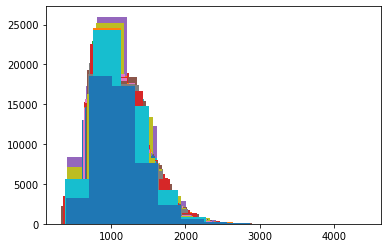

In [16]:

%timeit decision, rt =  batch_simulation(DDM_kernel_for_delay, coherence, sp, dg, sigma, bound, ndt)
# plt.hist(cp.asnumpy(rt))

<a id="Model_Performance_DDM"></a>

<br>
<br>
<br>

## C. Model Performance


| Model | Number of trials | Simulation time |
| --- | --- | --- |
|CPU Simulation | 10K | 6 secs | 
| CPU Simulation with Parallelization | 10K | 250 msec|

<br><h5><center>Further improvement in the model to accomodate dynamic input<center><h4><br>

| Model | Number of trials | Simulation time |
| --- | --- | --- |
| GPU Simulation with external diffusion process | 50K | 200 mses |
| GPU Simulation with internal diffusion process | 50K | 48.6 ms ± 168 µs |
| GPU Simulation with internal diffusion process with batch processing | 50K | 28.9 ms ± 121 µs |

<a id="Race"></a>

<br><br>

# 2. Race Model

Another competing model to explain such decisions is called Race model. This model is very similar to the DDM models with one key difference. Rather than having a single central accumulator for making a decision, it proposes two different accumulators, one for each choice, and whichever, accumulator reaches the threshold first will be the choice for that trial. Additionally, this model also have anothor restriction. The decision variable cannot be negative as we evidence cannot be negative. Hence, we set DV to zero whenever it goes below zero.  
    
<h4> The model illustration is shown below:</h4>

<center><img src=media/Race1.png  width="500"/></center>
    
The idea behind this model is as name suggests "race" between different decisions. You have two different accumulator, one for each choice. Each accumulator accumulates evidence for corresponding choice and whichever accumulator reaches the threshold bound first wins the race and that choice will be selected
<br></br>
<br></br>
<h4> Neural representation of the Race model:</h4>
   
<center><img src=media/Race2.png  width="250"/></center>

Another way of thinking about these model is that we could have two neurons which integrate the stimulus for one of the two choices. However, unlike DDM case, these neurons do not interact with each other.

<br></br>
<br></br>

The Race model can be mathematically formulated as: 

### <center>$ DV_{Left}(t+1) = DV_{Left}(t) + \mathcal{N}(r_{Left}, \sigma) $<center>

### <center>$ DV_{Right}(t+1) = DV_{Right}(t) + \mathcal{N}(r_{Right}, \sigma) $<center>
    
Where, <center>
       $DV_{Left}$ – Stimulus dependent decision variable for Left choice  
       $DV_{Right}$ – Stimulus dependent decision variable for Right choice  
       $r_{Left}$ – Drift factor for Left choice  
       $r_{Right}$ – Drift factor for Right choice  
       $\sigma$ – Drift variability  
       t – Time<center>
    
<br><br>
    


<a id="Basic_Implementation_Race"></a>

<br>

## A. Basic Implementation

##### `Initializing stimulus input and model parameters`

In [17]:
# Variables
coh = 52

sp1 = 0                   # starting point 1
sp2 = 0                   # starting point 2
dg1 = 10e-6               # drift gain 1
dg2 = 2*10e-6             # drift gain 2
sigma = 10e-3             # diffusion variability
I0 = 0.0002               # baseline input
dr1 = ReLU(coh)*dg1       # drift rate 1
dr2 = ReLU(-coh)*dg2      # drift rate 2
t = 0                     # time -> msec
bound = 1
ndt = 100                 # Non-decision time (msec)
stop_time = 10000

nTrials = 1000

##### `Model Simulation`

In [19]:
# Race Model
''' 
Considering latent observation of the stimulus.
Mainly driven by diffusion variability (if considering 0 input in opposite direction)
Good estimate in case of motion energy in random dots which also have some opposite direction component.
'''


diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 2
for tr in range(nTrials):
    dv1 = np.array([sp1],dtype=float32)       # Accumulator 1
    dv2 = np.array([sp2],dtype=float32)       # Accumulator 2
    for t in range(stop_time):
        dv1 = np.append(dv1, ReLU(dv1[t]+diffusion_step1[tr,t]))    # update decision variable 1
        dv2 = np.append(dv2, ReLU(dv2[t]+diffusion_step2[tr,t]))    # update decision variable 2
        if np.abs(dv1[t]) > bound:
            decision =  np.append(decision, 1)
            rt =  np.append(rt, t)
            break
        elif np.abs(dv2[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, -1)
            rt =  np.append(rt, t)
            break
            
else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 
rt =  rt+ndt

# plt.plot(dv1)
# plt.plot(dv2)
# plt.hist(rt)
# plt.show

<a id="LCA"></a>

<br><br>

# 3. Leaky-Competing Accumulator Model

So far we looked at two different models, one with complete suppression of all other accumulators and another with fully independent accumulator. The LCA models fills the methodological gap between these two models with having a partial inhibitory interaction among different accumulator (hence Competing). It also has a leak parameter which representing a leak in the evidence proportional to the evidence in specific accumulator. Similar to race model, this model also has non-negative evidence restriction.

    
<h4> The model illustration is shown below:</h4>

<center><img src=media/LCA1.png  width="500"/></center>
    
Similar to race models, winner takes all is the basic idea behind this model with additional interactions between different competing elements.
<br></br>
<br></br>
<h4> Neural representation of the Leaky-Competing Accumulator model:</h4>
   
<center><img src=media/LCA2.png  width="250"/></center>
<br>

Another way of thinking about these model is that we could have two neurons which integrate the stimulus for one of the two choices. These neurons have inhibitory connection to all other accumulator neurons in addition to information leak parameter represented by activity-dependent self inhibition. S  

<br></br>

The LCA model can be mathematically formulated as: 

### <center>$ DV_{Left}(t+1) = DV_{Left}(t) + \mathcal{N}(r_{Left}, \sigma) - Leak *  DV_{Left}(t) - LI * DV_{Right}(t) $<center>

### <center>$ DV_{Right}(t+1) = DV_{Right}(t) + \mathcal{N}(r_{Right}, \sigma) - Leak *  DV_{Right}(t) - LI * DV_{Left}(t) $<center>
    
Where, <center>
       $DV_{Left}$ – Stimulus dependent decision variable for Left choice  
       $DV_{Right}$ – Stimulus dependent decision variable for Right choice  
       $r_{Left}$ – Drift factor for Left choice  
       $r_{Right}$ – Drift factor for Right choice  
       $\sigma$ – Drift variability  
       LI - Lateral Inhibition factor
       t – Time<center>
    
<br><br>
    


<a id="Basic_Implementation_LCA"></a>

<br><br>

## A. Basic Implementation

##### `Initializing stimulus input and model parameters`

In [20]:

# Variables
coh = 51

sp1 = 0             # starting point 1
sp2 = 0             # starting point 2
dg1 = 10e-6       # drift gain 1
dg2 = 2*10e-6       # drift gain 2
sigma = 10e-3         # diffusion variability
I0 = 0.001         # baseline input
dr1 = ReLU(coh)*dg1       # first variable (input)
dr2 = ReLU(-coh)*dg2       # second variable (input)
leak = 0               # leak
lateral_inhibition = 0               # lateral inhibition
t = 0               # time -> msec
ndt = 100           # Non-decision time (msec)
stop_time = 10000

nTrials = 10000

##### `Model Simulation`

In [ ]:
%%time

diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=(nTrials, stop_time))
diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=(nTrials, stop_time))
for tr in range(nTrials):
    dv1 = np.array([sp1],dtype=float32)       # Accumulator 1
    dv2 = np.array([sp2],dtype=float32)       # Accumulator 2
    for t in range(stop_time):
        del_dv1 = diffusion_step1[tr,t] - leak*dv1[t] - lateral_inhibition*dv2[t] + I0    # change in accumulator 1
        del_dv2 = diffusion_step2[tr,t] - leak*dv2[t] - lateral_inhibition*dv1[t] + I0    # change in accumulator 2
        dv1 = np.append(dv1, ReLU(dv1[t]+del_dv1))    # update decision variable 1
        dv2 = np.append(dv2, ReLU(dv2[t]+del_dv2))    # update decision variable 2
        if np.abs(dv1[t]) > bound:
            decision =  np.append(decision, 1)
            rt =  np.append(rt, t)
            break
        elif np.abs(dv2[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, -1)
            rt =  np.append(rt, t)
            break
            
else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 
rt =  rt+ndt

# plt.hist(rt)
# plt.show


<a id="GPU_Implementation_LCA"></a>

<br>

## 2. GPU Implementation of LCA

<a id="Intrinsic_Diffusion_Process_LCA"></a>

<!-- <br><br> -->

### i. Intrinsic Diffusion Process

##### `Kernels for GPU parellelization and compilation`

In [24]:

@cuda.jit
def ReLU_cuda(input):
    return input * (input > 0)

# For Dynamic Coherence
@cuda.jit
def LCA_kernel_for_delay(coherence, sp1, sp2, dg1, dg2, sigma, bound, ndt, leak, lateral_inhibition, decision, rt, rng_states): 
    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (coherence.shape[0] - 1))   
    if tr_in_bounds:
        dv1 = sp1   # First accumulator                
        dv2 = sp2   # Second accumulator
        for t in range(coherence.shape[1]):
            diffusion_step1 = ReLU_cuda(coherence[tr,t]*dg1)  + (random.xoroshiro128p_normal_float32(rng_states, tr)*sigma)   
            diffusion_step2 = ReLU_cuda(-coherence[tr,t]*dg2) + (random.xoroshiro128p_normal_float32(rng_states, tr)*sigma)               
            del_dv1 = diffusion_step1 - leak*dv1 - lateral_inhibition*dv2    # change in accumulator 1
            del_dv2 = diffusion_step2 - leak*dv2 - lateral_inhibition*dv1    # change in accumulator 1
        
            dv1 = ReLU_cuda(dv1 + del_dv1)           # update decision variable
            dv2 = ReLU_cuda(dv2 + del_dv2)           # update decision variable
            
            if dv1 > bound[t]:
                decision[tr] =  1
                rt[tr] = t+ndt
                break
            if dv2 > bound[t]:
                decision[tr] =  -1
                rt[tr] = t+ndt
                break
                                
# Initializing DDM_Coherence_kernel with small variables
sp1=0
sp2=0
dg1 = 10e-6
dg2 = 10e-6
sigma = 10e-3         # diffusion variability
I0 = 0.001            # baseline input
leak = 0              # leak
lateral_inhibition = 0     # lateral inhibition
ndt=0
bound=1
coherence = cp.array([[100,100],[100,100]])
bound = cp.array([1,1])
decision = cp.empty(coherence.shape[0])*cp.NaN
rt = cp.empty(coherence.shape[0])*cp.NaN
blockdim = (16)
griddim = (coherence.shape[0] // blockdim) + 1
rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=1)
cuda.synchronize()
LCA_kernel_for_delay[griddim, blockdim](coherence, sp1, sp2, dg1, dg2, sigma, bound, ndt, leak, lateral_inhibition, decision, rt, rng_states)
cuda.synchronize()

##### `Initializing stimulus input and model parameters`

In [25]:
# Initializing DDM_Coherence_kernel with small variables
coh = 100
sp1=0
sp2=0
dg1 = 10e-6
dg2 = 10e-6
sigma = 10e-3         # diffusion variability
I0 = 0.001            # baseline input
leak = 0              # leak
lateral_inhibition = 0     # lateral inhibition
ndt=0
bound=1

if 'coherence' in globals():
    del coherence
coherence = cp.ones((50000, 10000), dtype=float32)*coh

bound = cp.ones(10000, dtype=float32)*bound

##### `Model Simulation`

In [26]:
%%timeit

decision = cp.empty(coherence.shape[0])*cp.NaN
rt = cp.empty(coherence.shape[0])*cp.NaN
blockdim = (16)
griddim = (coherence.shape[0] // blockdim) + 1
rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=1)

cuda.synchronize()
LCA_kernel_for_delay[griddim, blockdim](coherence, sp1, sp2, dg1, dg2, sigma, bound, ndt, leak, lateral_inhibition, decision, rt, rng_states)
cuda.synchronize()

51.8 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<a id="Intrinsic_Diffusion_Process_with_Batch_Processing_LCA"></a>

<!-- <br><br> -->

### ii. Intrinsic Diffusion Process with Batch Processing

##### `Model Simulation`

44.9 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


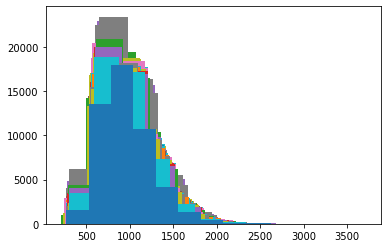

In [ ]:
def batch_simulation(model, coherence, sp1, sp2, dg1, dg2, sigma, bound, ndt, leak, lateral_inhibition, seed=None):
    batch_size = 10000;
    rt_np = []
    decision_np = []
    blockdim = int(128)
    griddim = (batch_size // blockdim) + 1
    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=seed)

    for i in range((coherence.shape[0]//batch_size)+1):
        coherence_batch = coherence[batch_size*i:batch_size*(i+1)]
        decision_cp = cp.empty(coherence_batch.shape[0])*cp.NaN
        rt_cp = cp.empty(coherence_batch.shape[0])*cp.NaN
        cuda.synchronize()
        model[griddim, blockdim](coherence_batch, sp1, sp2, dg1, dg2, sigma, bound, ndt, leak, lateral_inhibition, decision_cp, rt_cp, rng_states);
        cuda.synchronize()
        decision_np = np.append(decision_np, cp.asnumpy(decision_cp))
        rt_np = np.append(rt_np, cp.asnumpy(rt_cp))
    plt.hist(rt_np)
    return decision_np, rt_np

%timeit decision, rt =  batch_simulation(LCA_kernel_for_delay, coherence, sp1, sp2, dg1, dg2, sigma, bound, ndt, leak, lateral_inhibition)
    


<br><br>

<center><h3>Leaky-Competing Accumulator Model - Simulation Results<h3><centert>

| Model | Number of trials | Simulation time |
| --- | --- | --- |
| CPU Simulation | 10K | 2.5 secs |
| GPU Simulation with internal diffusion process | 50K | 47.4 ms ± 388 µs |
| GPU Simulation with internal diffusion process with batch processing | 50K | 41.4 ms ± 654 µs |

# Latent Drift-Diffusion Model

In [ ]:
# Latent DDM
''' 
Considering latent observation of the stimulus.
Mainly driven by diffusion variability (if considering 0 input in opposite direction)
Good estimate in case of motion energy in random dots also have some opposite direction motion.

Mathematically equivalent to running DDM with diffusion of sqrt(2)*sigma instead of sigma

'''

# Variables
coh = 52

sp1 = 0                   # starting point 1
sp2 = 0                   # starting point 2
dg1 = 10e-6               # drift gain 1
dg2 = 2*10e-6             # drift gain 2
sigma = 10e-3             # diffusion variability
I0 = 0.0002               # baseline input
dr1 = ReLU(coh)*dg1       # drift rate 1
dr2 = ReLU(-coh)*dg2      # drift rate 2
t = 0                     # time -> msec
ndt = 100                 # Non-decision time (msec)
stop_time = 10000

nTrials = 1000
diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 2
for tr in range(nTrials):
    x1 = np.array([sp1],dtype=float32)       # Accumulator 1
    x2 = np.array([sp2],dtype=float32)       # Accumulator 2
    for t in range(stop_time):
        x1 = np.append(x1, x1[t]+diffusion_step1[tr,t])    # update decision variable 1
        x2 = np.append(x2, x2[t]+diffusion_step2[tr,t])    # update decision variable 2
        if np.abs(x1[t]-x2[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, np.sign(x1[t]-x2[t]))
            rt =  np.append(rt, t)
            break

else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 
rt =  rt+ndt

# plt.plot(x1,'b')
# plt.plot(x2,'g')
# plt.plot(dv,'r')
plt.hist(rt)
plt.show

# Working unused functinos

In [ ]:
                
# Matrix multiplication with LARGE matric and a scale or vector on GPU 
@cuda.jit
def matmult_cuda(matrix, scalar):
    row,col = cuda.grid(2)
    row_in_bounds = (row >= 0) and (row <= (matrix.shape[0] - 1))
    col_in_bounds = (col >= 0) and (col <= (matrix.shape[1] - 1))
    if row_in_bounds and col_in_bounds:
        matrix[row,col] = scalar*matrix[row,col]
# Initializing matmult_cuda function
test_mat = cp.array([[2,3,5],[4,5,5]],dtype=float32)
test_scalar = np.float32(3)
blockdim = (16, 16)
griddim = (test_mat.shape[0] // blockdim[0]) + 1, (test_mat.shape[1] // blockdim[1]) + 1
%time matmult_cuda[griddim, blockdim](test_mat, test_scalar)
        
                
        
# Memory allotment trick
def ddm_kernel(coh,nTrials,pars,stop_time,decision, rt):
    tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    ty = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_size = cuda.blockDim.x  # number of threads per block
    grid_size = cuda.gridDim.x    # number of blocks in the grid
    
    start = tx + ty * block_size
    stride = block_size * grid_size

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]


# For single Coherence
@cuda.jit
def DDM_kernel(nTrials,pars,stop_time, diffusion_step, decision, rt): 

    sp = pars[0]             # starting point 1
    dg = pars[1]             # drift gain
    sigma = pars[2]          # diffusion variability
    ndt = pars[3]            # Non-decision time (msec)
    bound = pars[4]          # drift rate
    t = 0                    # time -> msec

    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (nTrials - 1))
    
    if tr_in_bounds:
        dv = sp
        for t in range(stop_time):
            dv = dv + diffusion_step[tr,t]      # update decision variable
            if dv > bound or dv < -bound:       # checking if decision bound is reached
                decision[tr] =  2*(dv>0) - 1    # np.sign(dv) alternative for making decision based on where evidence is maximum
                rt[tr] = t+ndt
                break  


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>



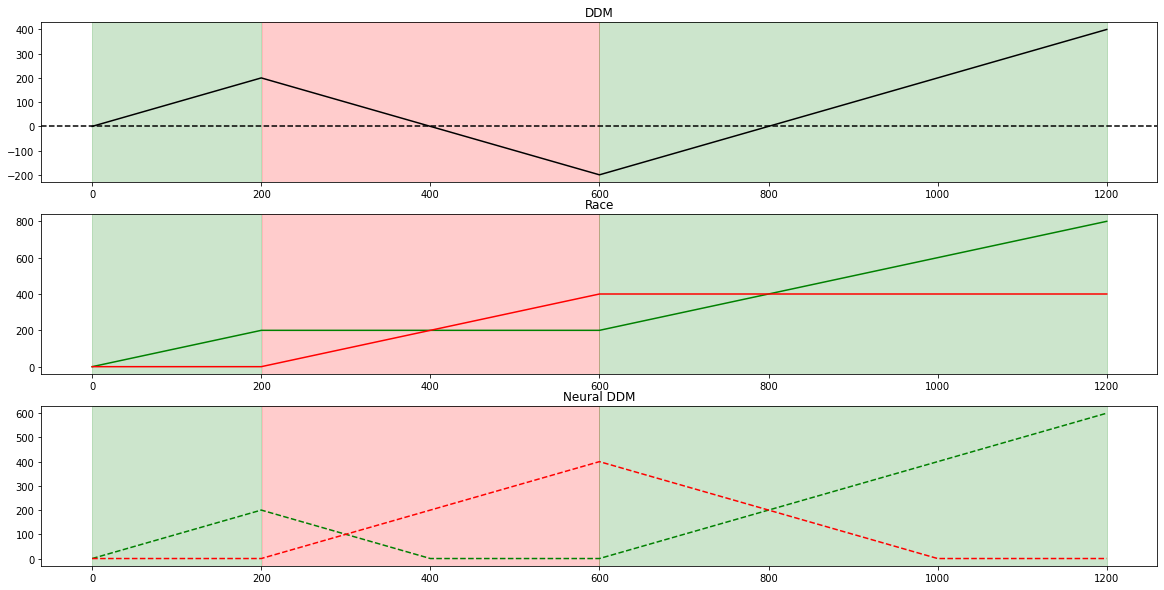

In [148]:
# Stimulus +--++++
coherence = np.ones(2000)*100
coherence[200:600] = -coherence[200:600]

coherence_unified = get_unsigned_coherence_matrix(coherence)


# Input Parameters
sp1 = 0                   # starting point 1
sp2 = 0                   # starting point 2
dg1 = .01#0e-6               # drift gain 1
dg2 = .01#0e-6               # drift gain 2
sigma = 10e-3             # diffusion variability
dr = coherence*dg1            # decision variable (DDM)
dr1 = ReLU(coherence)*dg1     # decision variable (Race1)
dr2 = ReLU(-coherence)*dg2    # decision variable (Race2)
dr1_unified = coherence_unified[0]*dg1     # decision variable (Race1)
dr2_unified = coherence_unified[1]*dg2    # decision variable (Race2)
leak = 0                      # leak
lateral_inhibition = 0.5      # lateral inhibition
unified_constant = 1          # DDM-Race unification constant
ndt = 100                     # Non-decision time (msec)
stop_time = 2000



decision = np.array([],dtype=float32)       # Collect decision on each trial
rt = np.array([],dtype=float32)             # Collect reaction time for each trial


# diffusion_step = np.random.normal(loc=dr,  scale=sigma, size=stop_time)    # change in DDM accumulator
# diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=stop_time)    # change in Race1 accumulator
# diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=stop_time)    # change in Race2 accumulator

dv = np.array([sp1],dtype=float64)   # DDM decision variable
dv1 = np.array([sp1],dtype=float64)  # Race1 decision variable
dv2 = np.array([sp1],dtype=float64)  # Race2 decision variable
dv1_unified = np.array([sp1],dtype=float64)  # Race2 decision variable
dv2_unified = np.array([sp1],dtype=float64)  # Race2 decision variable


# for t in range(stop_time):
for t in range(1200):
    dv =  np.append(dv, dv[t]   + dr[t])                                 # update DDM decision variable
    dv1 = np.append(dv1, dv1[t] + dr1[t])                                # update DDM decision variable
    dv2 = np.append(dv2, dv2[t] + dr2[t])                                # update DDM decision variable    

    
    dv1_unified = np.append(dv1_unified, ReLU(dv1_unified[t] + dr1_unified[t] - dr2_unified[t]))#lateral_inhibition*dv2_unified[t]))                                # update DDM decision variable
    dv2_unified = np.append(dv2_unified, ReLU(dv2_unified[t] + dr2_unified[t] - dr1_unified[t]))#lateral_inhibition*dv1_unified[t]))  
    
    
#     dv1_unified = np.append(dv1_unified, ReLU(dv1_unified[t] + dr1_unified[t] - lateral_inhibition*dv2_unified[t]))                                # update DDM decision variable
#     dv2_unified = np.append(dv2_unified, ReLU(dv2_unified[t] + dr2_unified[t] - lateral_inhibition*dv1_unified[t]))  
    
    
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(3, 1)    
ax[0].plot(dv,'k')
ax[0].axhline(y=0, color = 'k', ls='--')
ax[0].title.set_text('DDM')

ax[1].plot(dv1,'g')
ax[1].plot(dv2,'r')
ax[1].title.set_text('Race')

ax[2].plot(dv1_unified,'g--')
ax[2].plot(dv2_unified,'r--')
ax[2].title.set_text('Neural DDM')

for i in range(3):
    ax[i].axvspan(0, 200, alpha=0.2, color='green')
    ax[i].axvspan(201, 600, alpha=0.2, color='red')
    ax[i].axvspan(600, 1200, alpha=0.2, color='green')
# ax[0].set_xlim([190, 210])
# ax[1].set_xlim([190, 210])
# ax[2].set_xlim([190, 210])

In [132]:
dv[-1], dv1_unified[-1]

(1200.0, 1600.0)